# Loading Data

In [1]:
from numbers import Number
from collections import defaultdict

import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

import sina.datastores.sql as sina_sql
import sina.utils
from sina.datastore import create_datastore
from sina.visualization import Visualizer
from sina.model import Record, generate_record_from_json
import math
import statistics
import numpy as np

%matplotlib notebook

# Initialization
database = '../04_manage_data/data/ensembles_output.sqlite'
target_type = "csv_rec"
datastore = create_datastore(database)
recs = datastore.records
vis = Visualizer(datastore)
print("Sina is ready!")



# Baseline Initialization
database_baseline = '../01_baseline_simulation/baseline/data/baseline_output.sqlite'
datastore_baseline = create_datastore(database_baseline)
recs_baseline = datastore_baseline.records

val = recs_baseline.get('47bcda_0')
print(val.data.keys()) # since there are no embedded keys we can just use this
#print(val.curve_sets) # no curve sets



x_true = val.data['x_pos']['value']
y_true = val.data['y_pos']['value']
z_true = val.data['z_pos']['value']
time_true = val.data['time']['value']


Sina is ready!
dict_keys(['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial', 'gravity', 'box_side_length', 'group_id', 'time', 'x_pos', 'y_pos', 'z_pos', 'x_vel_final', 'y_vel_final', 'z_vel_final', 'num_bounces'])


# Adding Data to Records

In [6]:
mean_rec = Record(id= "mean", type="summary")
recs.delete("mean")

x_temp = []
y_temp = []
z_temp = []

x_mean = []
y_mean = []
z_mean = []
x_std = []
y_std = []
z_std = []

for i , t in enumerate(time_true):
    
    for rec in recs.get_all():

        x_pred = rec.data['x_pos']['value'][i]
        y_pred = rec.data['y_pos']['value'][i]
        z_pred = rec.data['z_pos']['value'][i]

        x_temp.append(x_pred)
        y_temp.append(y_pred)
        z_temp.append(z_pred)
        
        if i == len(time_true) - 1 :
            rec.add_data('x_pos_final', x_pred)
            rec.add_data('y_pos_final', y_pred)
            rec.add_data('z_pos_final', z_pred)
            recs.update(rec)
            
        
    x_mean.append(statistics.mean(x_temp))
    y_mean.append(statistics.mean(y_temp))
    z_mean.append(statistics.mean(z_temp))
    x_std.append(statistics.stdev(x_temp))
    y_std.append(statistics.stdev(y_temp))
    z_std.append(statistics.stdev(z_temp))
    
    x_temp = []
    y_temp = []
    z_temp = []

mean_rec.add_data('time',time_true)
mean_rec.add_data('x_pos_mean',x_mean)
mean_rec.add_data('y_pos_mean',y_mean)
mean_rec.add_data('z_pos_mean',z_mean)
mean_rec.add_data('x_pos_std',x_std)
mean_rec.add_data('y_pos_std',y_std)
mean_rec.add_data('z_pos_std',z_std)    

mean_rec.add_data('x_pos_mean_plus_std', [ x_mean[i] + x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_plus_std', [ y_mean[i] + y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_plus_std', [ z_mean[i] + z_std[i] for i in range (len (time_true))])
mean_rec.add_data('x_pos_mean_minus_std', [ x_mean[i] - x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_minus_std', [ y_mean[i] - y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_minus_std', [ z_mean[i] - z_std[i] for i in range (len (time_true))])

mean_rec.add_data('x_pos_mean_plus_2std', [ x_mean[i] + 2*x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_plus_2std', [ y_mean[i] + 2*y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_plus_2std', [ z_mean[i] + 2*z_std[i] for i in range (len (time_true))])
mean_rec.add_data('x_pos_mean_minus_2std', [ x_mean[i] - 2*x_std[i] for i in range (len (time_true))])
mean_rec.add_data('y_pos_mean_minus_2std', [ y_mean[i] - 2*y_std[i] for i in range (len (time_true))])
mean_rec.add_data('z_pos_mean_minus_2std', [ z_mean[i] - 2*z_std[i] for i in range (len (time_true))])

recs.insert(mean_rec) # need to update or else won't save!!!!!    
    

# Plotting Options

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scalars= ["x_pos_final", "y_pos_final", "z_pos_final"]
parameters = ['x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial']
convergence=[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
n_bins = int(math.sqrt(convergence[-1]))

# QoI transient data with uncertainty bounds

<IPython.core.display.Javascript object>


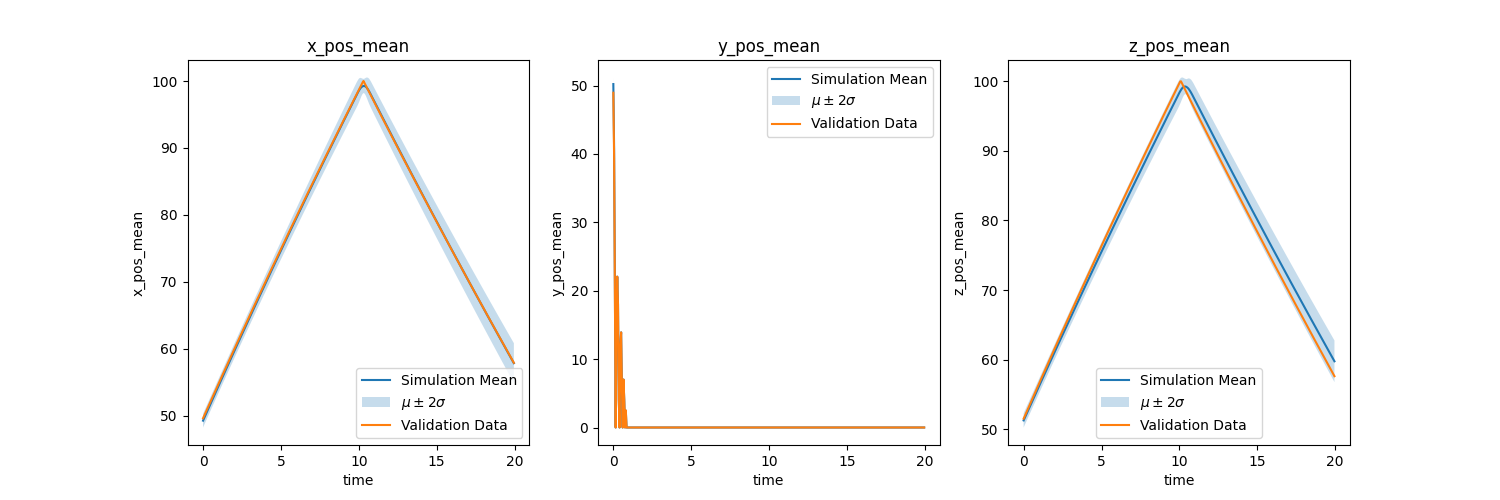

In [2]:
mean = recs.get('mean')
time = mean.data['time']['value']
x_pos_mean_plus_2std = mean.data['x_pos_mean_plus_2std']['value']
y_pos_mean_plus_2std = mean.data['y_pos_mean_plus_2std']['value']
z_pos_mean_plus_2std = mean.data['z_pos_mean_plus_2std']['value']

x_pos_mean_minus_2std = mean.data['x_pos_mean_minus_2std']['value']
y_pos_mean_minus_2std = mean.data['y_pos_mean_minus_2std']['value']
z_pos_mean_minus_2std = mean.data['z_pos_mean_minus_2std']['value']


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))



_ = vis.create_line_plot(fig=fig, ax=ax[0],x="time", y="x_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[1],x="time", y="y_pos_mean", title = "{y_name}", id_pool=['mean'])
_ = vis.create_line_plot(fig=fig, ax=ax[2],x="time", y="z_pos_mean", title = "{y_name}", id_pool=['mean'])



ax[0].fill_between(time,x_pos_mean_plus_2std,x_pos_mean_minus_2std, alpha=0.25)
ax[1].fill_between(time,y_pos_mean_plus_2std,y_pos_mean_minus_2std, alpha=0.25)
ax[2].fill_between(time,z_pos_mean_plus_2std,z_pos_mean_minus_2std, alpha=0.25)

ax[0].plot(time_true, x_true)
ax[1].plot(time_true, y_true)
ax[2].plot(time_true, z_true)


ax[0].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[1].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
ax[2].legend(labels=['Simulation Mean','$\mu \pm 2 \sigma$','Validation Data'])
fig.savefig("./images/QoIs_u_input.png")

# QoI point data violin and box plots

<IPython.core.display.Javascript object>


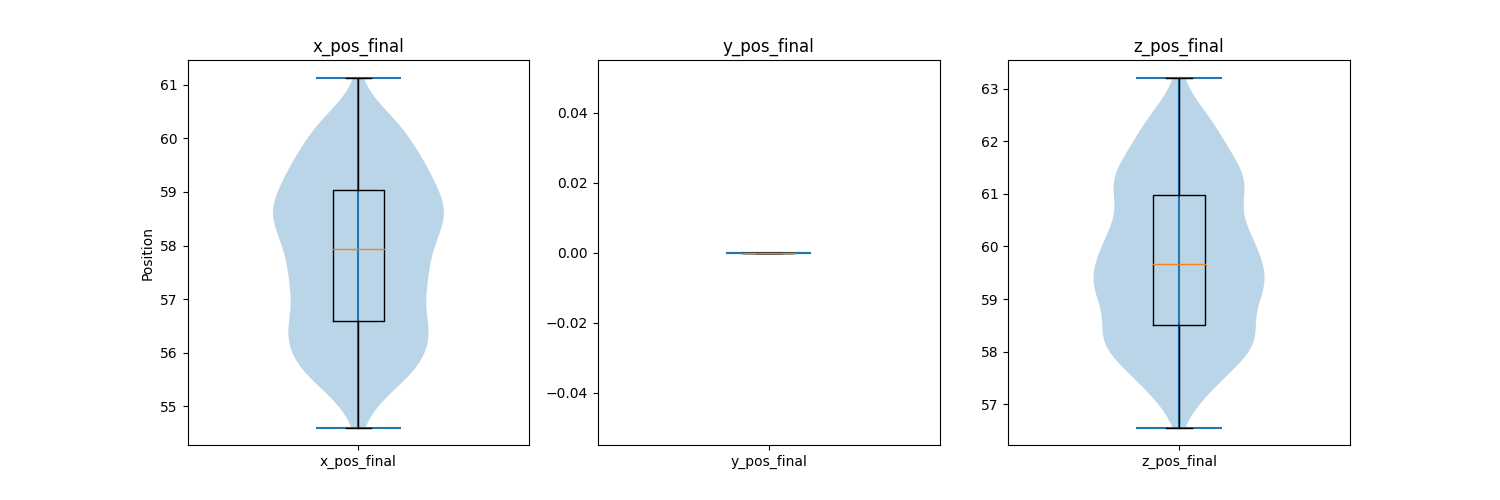

In [92]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

final_data = recs.get_data(scalars)

x_pos_final = [x["x_pos_final"]["value"] for x in final_data.values()]
y_pos_final = [x["y_pos_final"]["value"] for x in final_data.values()]
z_pos_final = [x["z_pos_final"]["value"] for x in final_data.values()]


ax[0].violinplot(x_pos_final)
ax[0].boxplot(x_pos_final)
ax[1].violinplot(y_pos_final)
ax[1].boxplot(y_pos_final)
ax[2].violinplot(z_pos_final)
ax[2].boxplot(z_pos_final)

ax[0].set_title("x_pos_final")
ax[0].set_ylabel("Position")
ax[0].set_xticklabels(["x_pos_final"])

ax[1].set_title("y_pos_final")
ax[1].set_xticklabels(["y_pos_final"])

ax[2].set_title("z_pos_final")
ax[2].set_xticklabels(["z_pos_final"])

fig.savefig("./images/QoIs_violin_box.png")

# QoI point data violin and box convergence plots

<IPython.core.display.Javascript object>


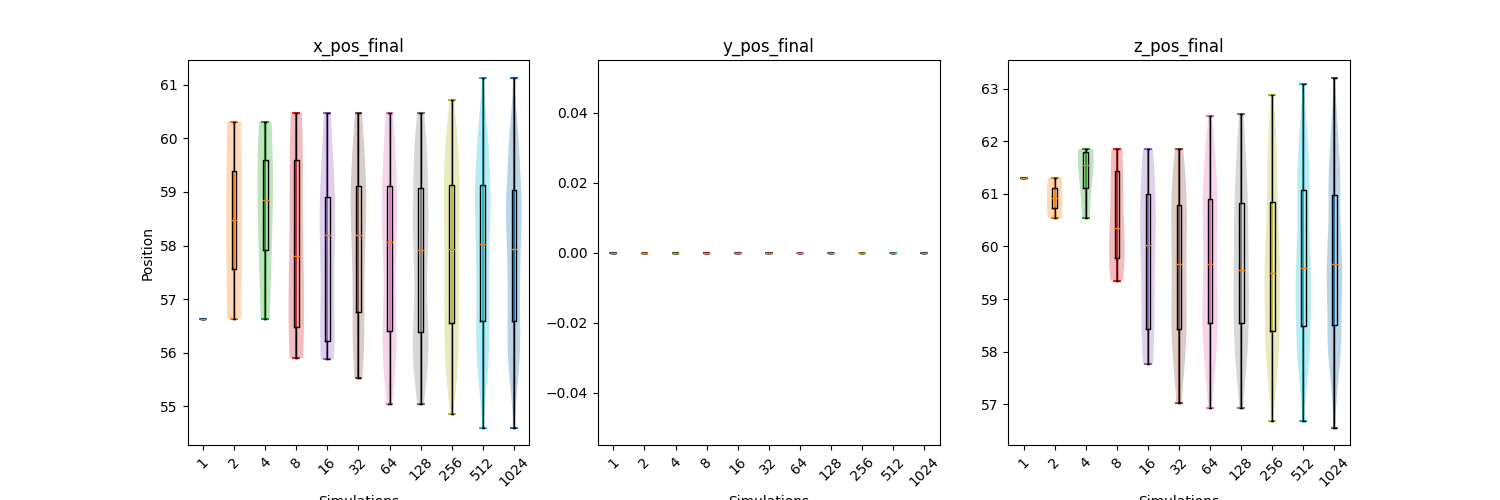

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, runs in enumerate(convergence):
    convergence_ids = [ "09cd18_"+str(x+1) for x in range(runs)]
#     print(convergence_ids)
    
    
    if runs == convergence[-1]: # will error if all ids are present
        final_data = recs.get_data(scalars)
    else:
        final_data = recs.get_data(scalars,id_list=convergence_ids)

    x_pos_final = [x["x_pos_final"]["value"] for x in final_data.values()]
    y_pos_final = [x["y_pos_final"]["value"] for x in final_data.values()]
    z_pos_final = [x["z_pos_final"]["value"] for x in final_data.values()]


    ax[0].violinplot(x_pos_final, positions = [i])
    ax[0].boxplot(x_pos_final, positions = [i])
    ax[1].violinplot(y_pos_final, positions = [i])
    ax[1].boxplot(y_pos_final, positions = [i])
    ax[2].violinplot(z_pos_final, positions = [i])
    ax[2].boxplot(z_pos_final, positions = [i])
    
ax[0].set_title("x_pos_final")
ax[0].set_xlabel("Simulations")
ax[0].set_ylabel("Position")
ax[0].set_xticklabels(convergence, rotation = 45)

ax[1].set_title("y_pos_final")
ax[1].set_xlabel("Simulations")
ax[1].set_xticklabels(convergence, rotation = 45)

ax[2].set_title("z_pos_final")
ax[2].set_xlabel("Simulations")
ax[2].set_xticklabels(convergence, rotation = 45)

fig.savefig("./images/QoIs_violin_box_convergence.png")

# QoI point data PDF and CDF plots

<IPython.core.display.Javascript object>


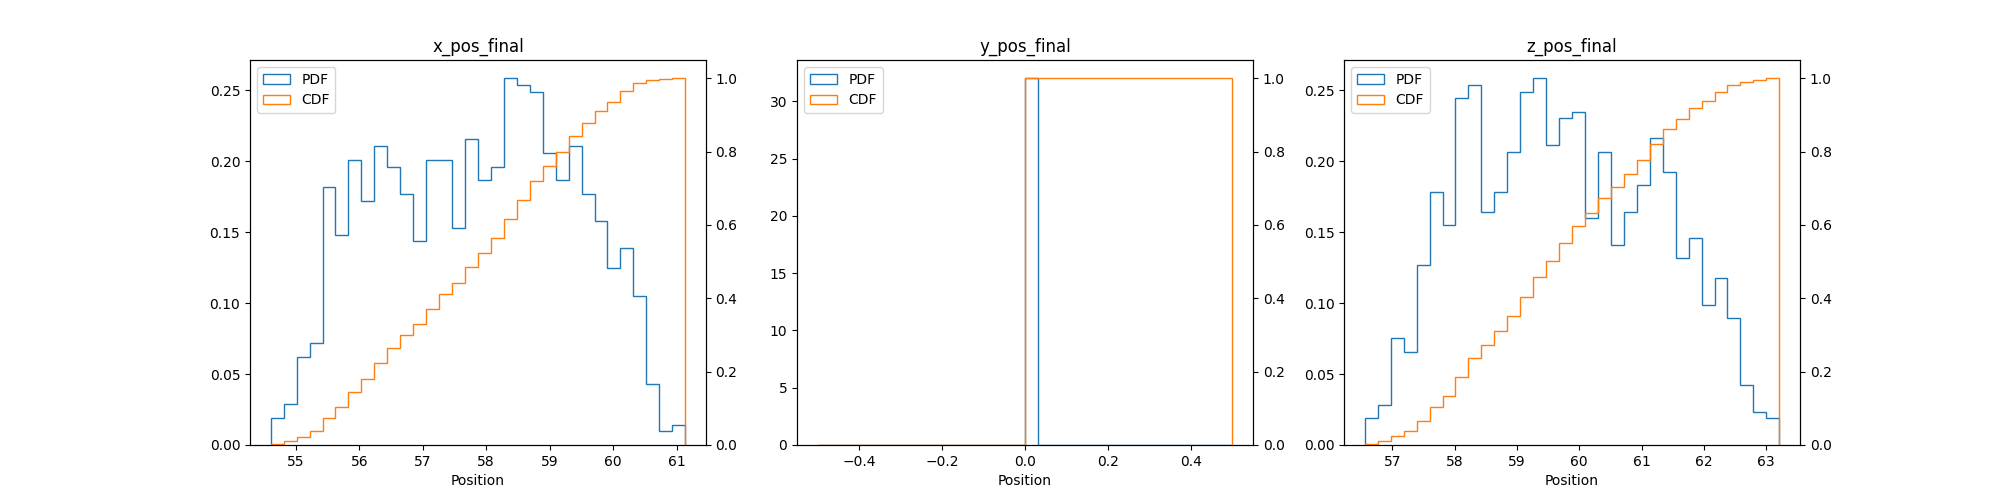

In [137]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax1 = []
ax1.append(ax[0].twinx())
ax1.append(ax[1].twinx())
ax1.append(ax[2].twinx())
# _ = vis.create_histogram(fig=fig, ax=ax[0],x="x_pos_final")
# _ = vis.create_histogram(fig=fig, ax=ax[1],x="y_pos_final")
# _ = vis.create_histogram(fig=fig, ax=ax[2],x="z_pos_final")
    
final_data = recs.get_data(scalars)

x_pos_final = [x["x_pos_final"]["value"] for x in final_data.values()]
y_pos_final = [x["y_pos_final"]["value"] for x in final_data.values()]
z_pos_final = [x["z_pos_final"]["value"] for x in final_data.values()]

ax[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, label = 'PDF')
ax1[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, color = colors[1], label = 'CDF')

ax[0].set_title("x_pos_final")
ax[0].set_xlabel("Position")
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax1[0].get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper left')


ax[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True)
ax1[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, color = colors[1])

ax[1].set_title("y_pos_final")
ax[1].set_xlabel("Position")
ax[1].legend(lines + lines2, labels + labels2, loc='upper left')


ax[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True)
ax1[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, color = colors[1])

ax[2].set_title("z_pos_final")
ax[2].set_xlabel("Position")
ax[2].legend(lines + lines2, labels + labels2, loc='upper left')

fig.savefig("./images/QoIs_pdf_cdf.png")

# QoI point data PDF and CDF convergence plots

<IPython.core.display.Javascript object>


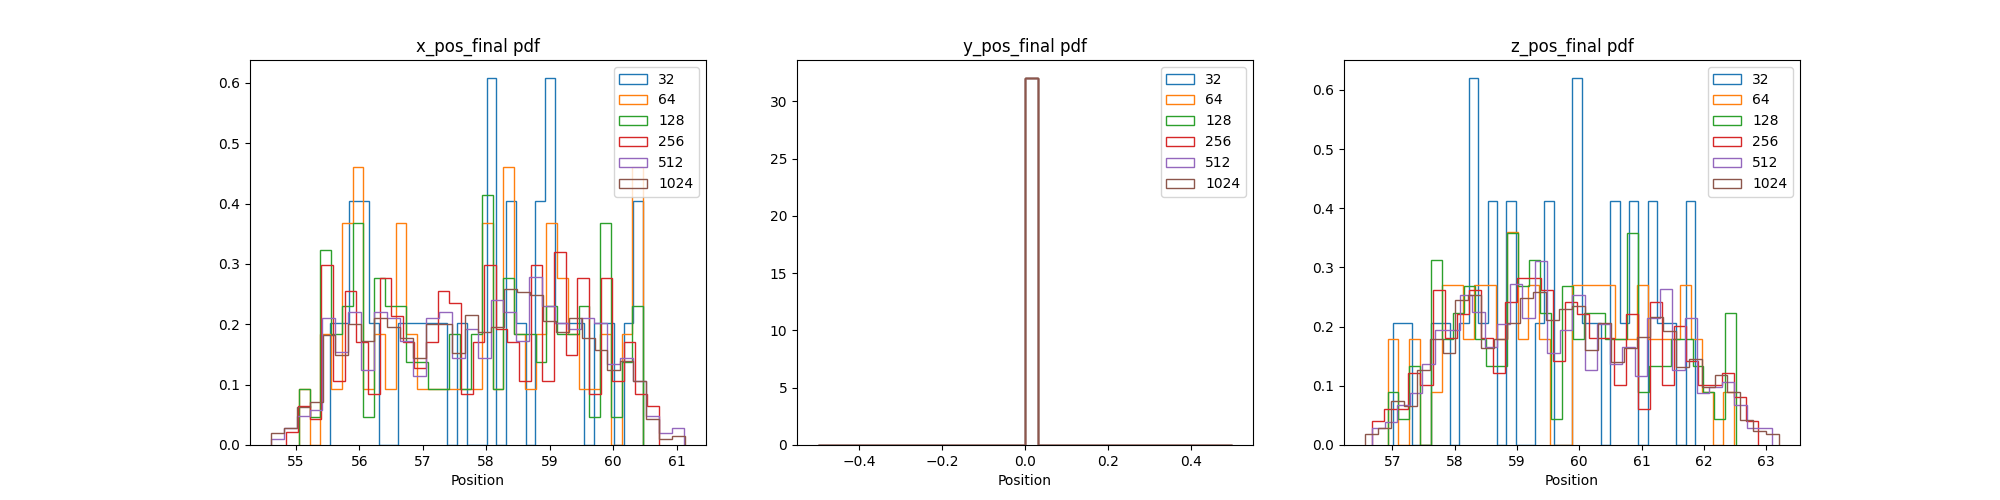

<IPython.core.display.Javascript object>


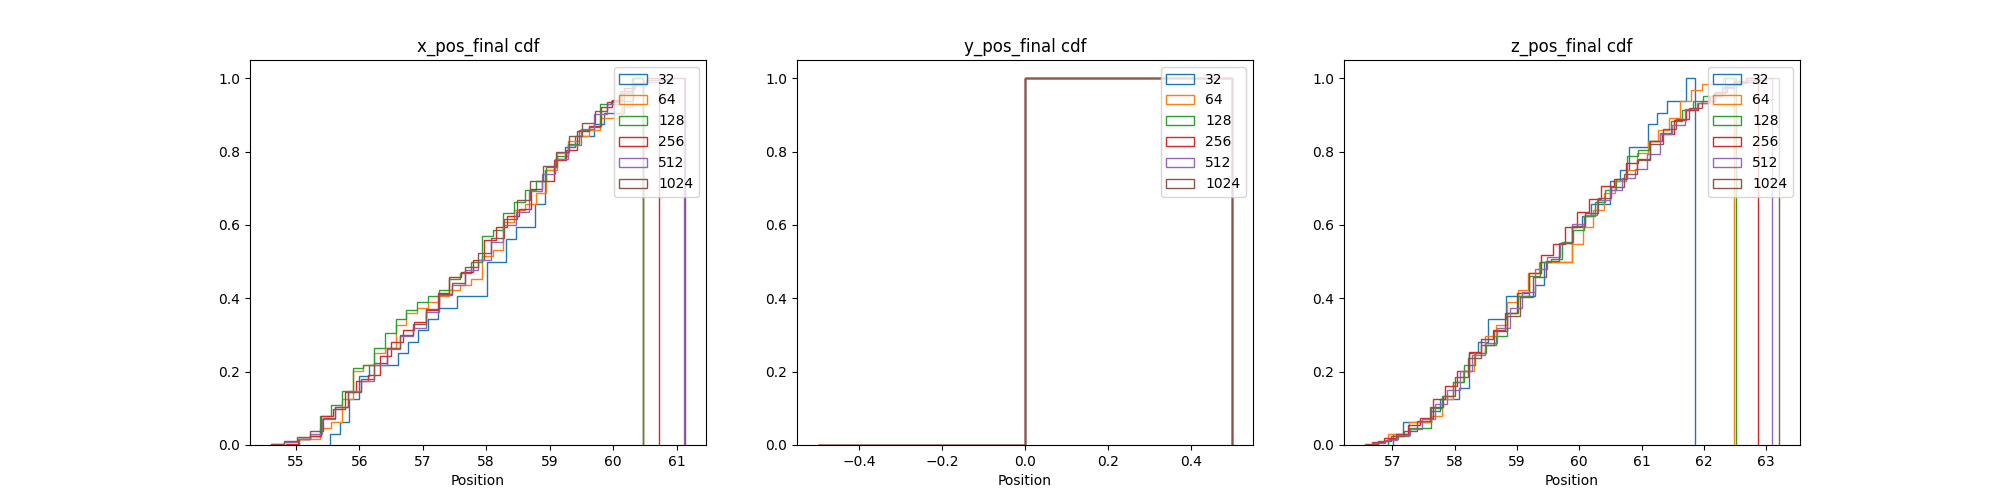

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig1, ax1 = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# _ = vis.create_histogram(fig=fig, ax=ax[0],x="x_pos_final")
# _ = vis.create_histogram(fig=fig, ax=ax[1],x="y_pos_final")
# _ = vis.create_histogram(fig=fig, ax=ax[2],x="z_pos_final")

for i, runs in enumerate(convergence[5:]): # depending on number of runs, can obscure the rest 
    convergence_ids = [ "09cd18_"+str(x+1) for x in range(runs)]
#     print(convergence_ids)
    
    
    if runs == convergence[-1]: # will error if all ids are present
        final_data = recs.get_data(scalars)
    else:
        final_data = recs.get_data(scalars,id_list=convergence_ids)

    x_pos_final = [x["x_pos_final"]["value"] for x in final_data.values()]
    y_pos_final = [x["y_pos_final"]["value"] for x in final_data.values()]
    z_pos_final = [x["z_pos_final"]["value"] for x in final_data.values()]

    
    ax[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, label = runs)
    ax[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True, label = runs)
    ax[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True, label = runs)    
    
    ax1[0].hist(x_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, label = runs)
    ax1[1].hist(y_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, label = runs)
    ax1[2].hist(z_pos_final, bins=n_bins, histtype='step', density=True, cumulative=True, label = runs)   
    
    
ax[0].set_title("x_pos_final pdf")
ax[0].set_xlabel("Position")
ax[0].legend()

ax[1].set_title("y_pos_final pdf")
ax[1].set_xlabel("Position")
ax[1].legend()

ax[2].set_title("z_pos_final pdf")
ax[2].set_xlabel("Position")
ax[2].legend()

fig.savefig("./images/QoIs_pdf_convergence.png")


ax1[0].set_title("x_pos_final cdf")
ax1[0].set_xlabel("Position")
ax1[0].legend()

ax1[1].set_title("y_pos_final cdf")
ax1[1].set_xlabel("Position")
ax1[1].legend()

ax1[2].set_title("z_pos_final cdf")
ax1[2].set_xlabel("Position")
ax1[2].legend()

fig1.savefig("./images/QoIs_cdf_convergence.png")

# QoI point data parameter correlation scatter plots

Negative correlation because bouncing off the wall quicker if your further out or faster

<IPython.core.display.Javascript object>


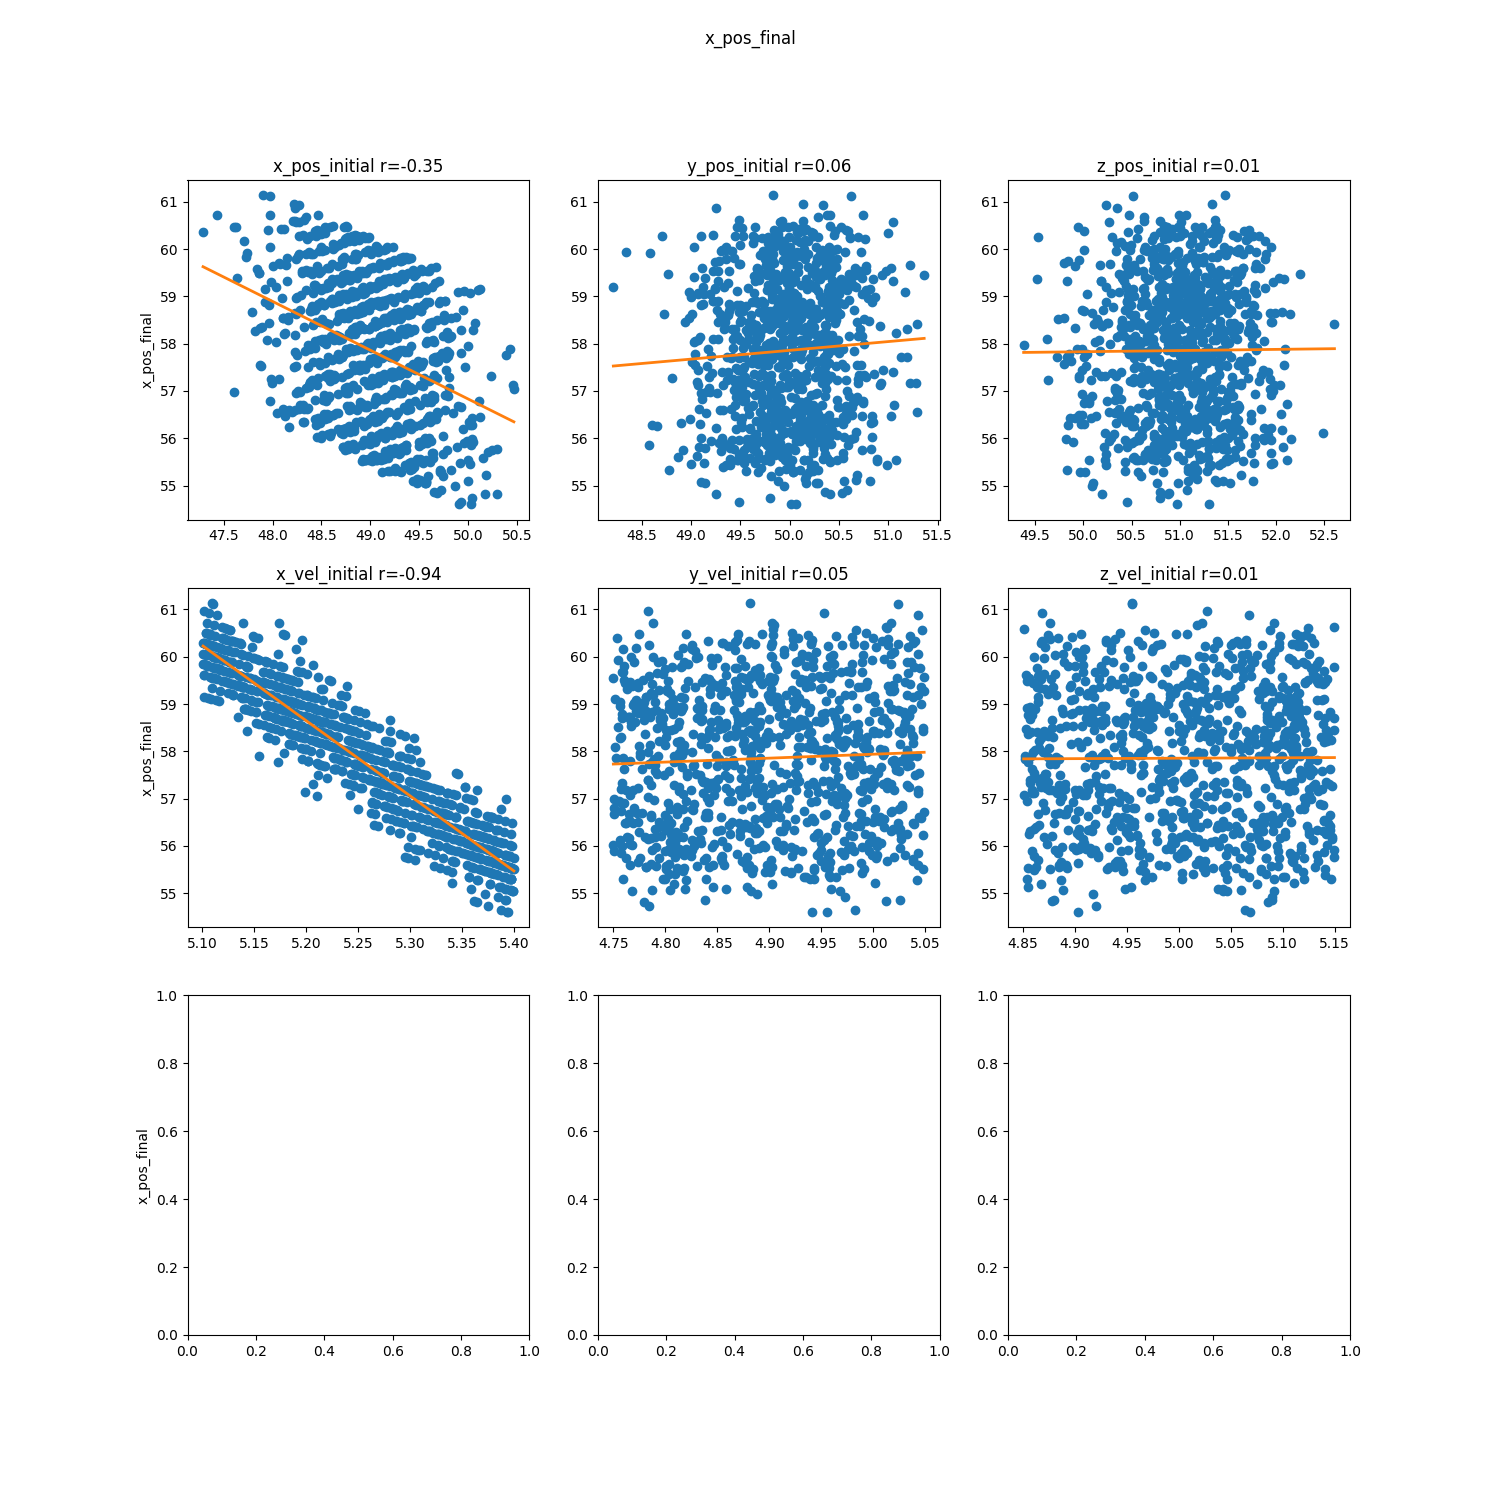

<IPython.core.display.Javascript object>


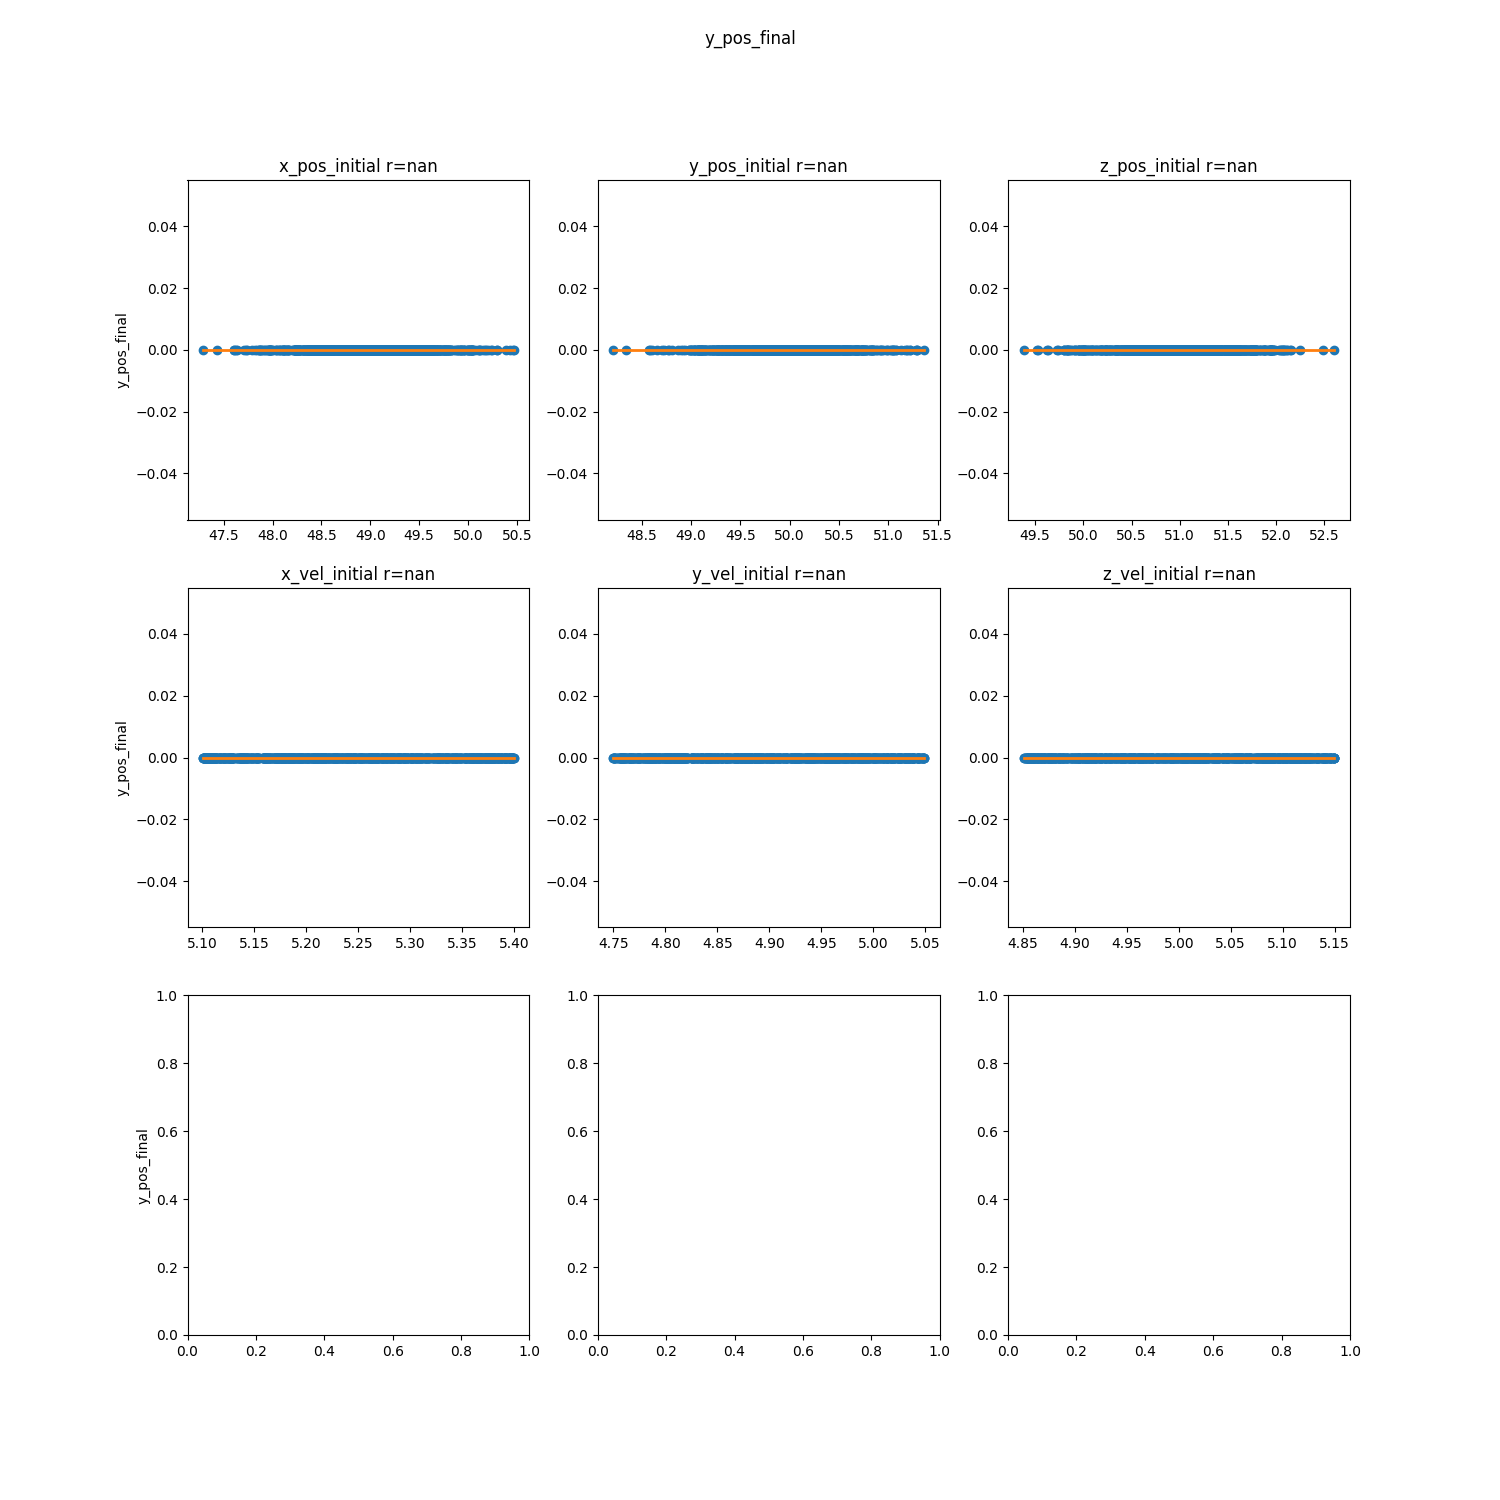

/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib64/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib64/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib64/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib64/python3.6/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/g/g20/moreno45/Projects/WEAVE/weave_demos/ball_bounce/ball_bounce_demo_venv/lib64/python3.6/site-packages/numpy/lib/fun

<IPython.core.display.Javascript object>


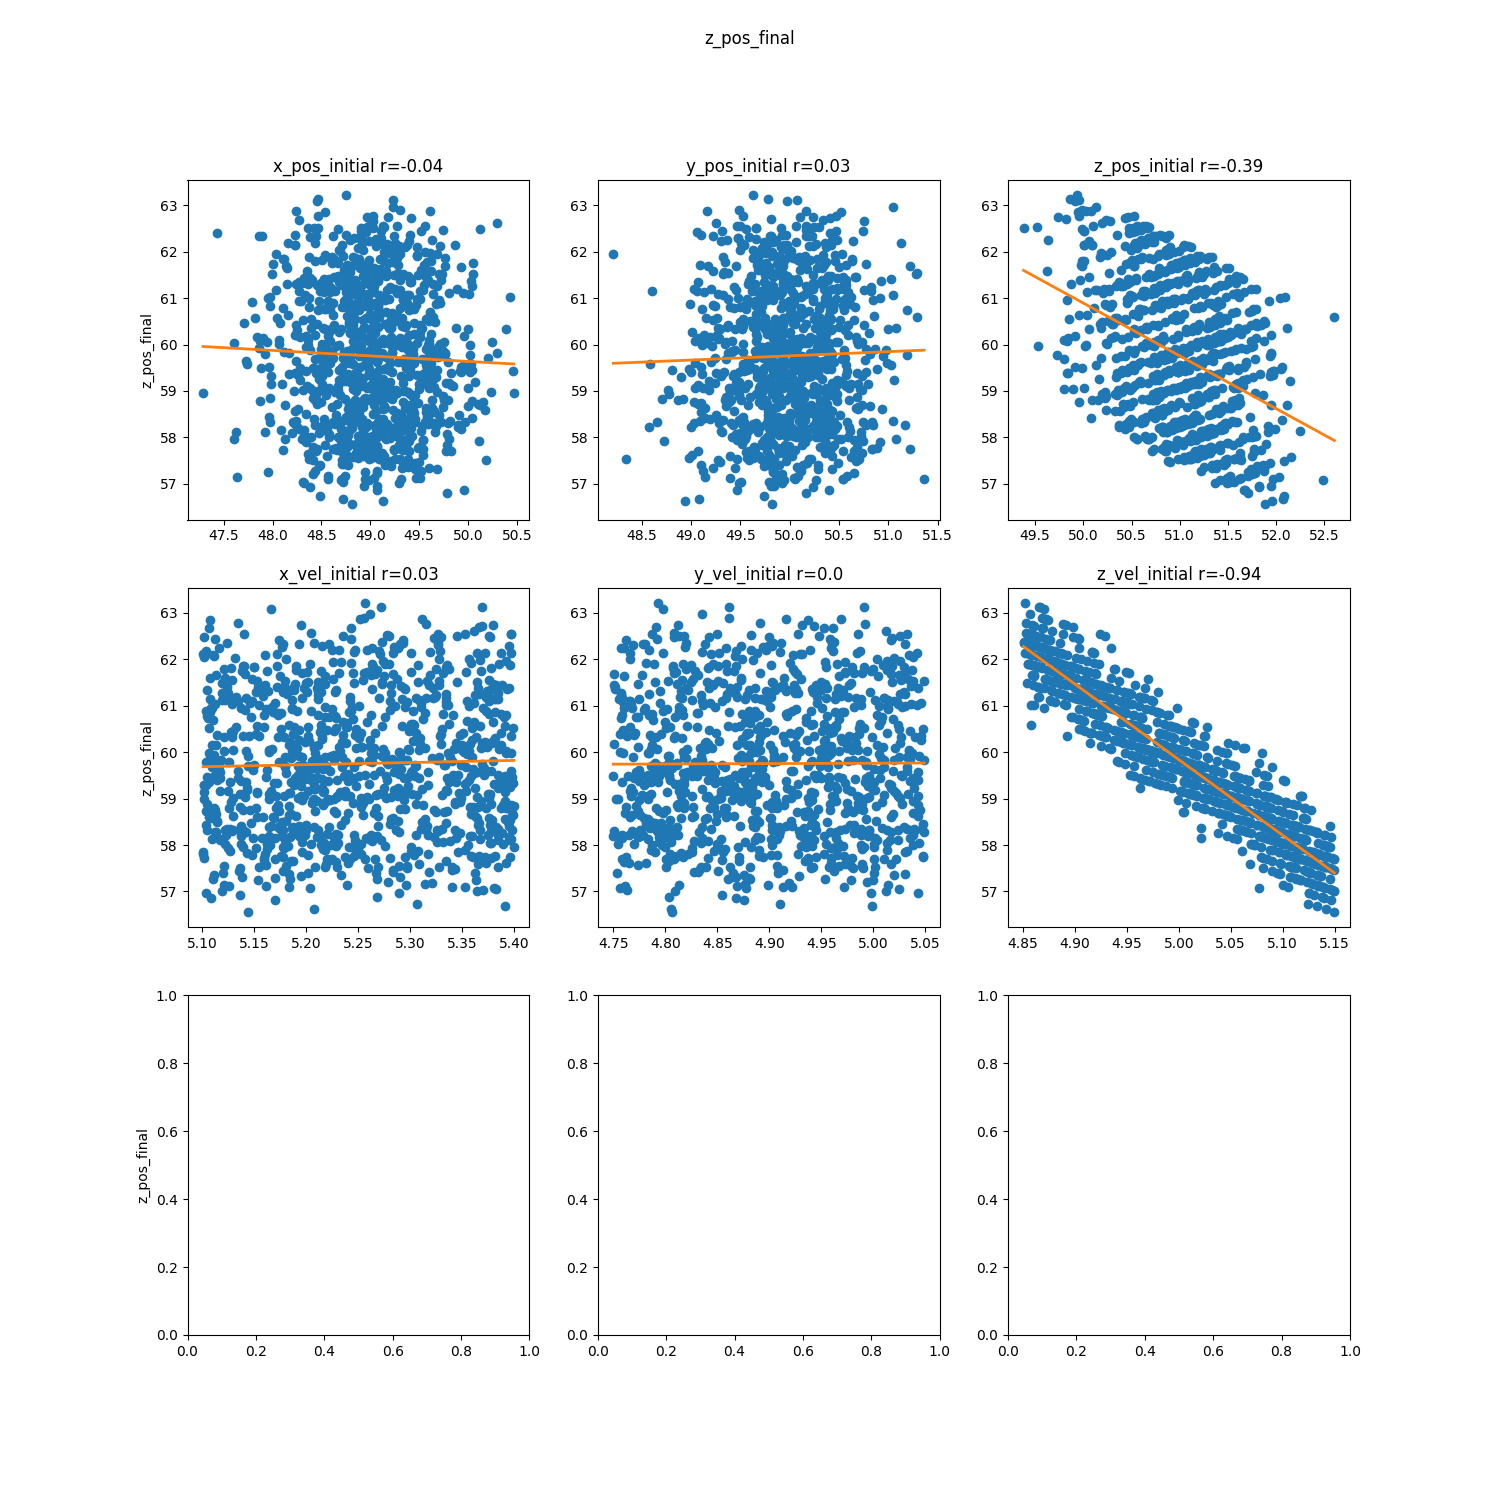

In [7]:
num_plts = len(parameters)
rows_cols = math.ceil(math.sqrt(num_plts))

all_scalars = scalars + parameters
final_data = recs.get_data(all_scalars)


for scalar in scalars:
    
    fig, ax = plt.subplots(nrows=rows_cols, ncols=rows_cols, figsize=(rows_cols*5, rows_cols*5))
    
    fig.suptitle(scalar)
    scalar_values = [x[scalar]["value"] for x in final_data.values()]
    
    i=0
    j=0
    ax[j,i].set_ylabel(scalar)
    
    for parameter in parameters:

        parameter_values = [x[parameter]["value"] for x in final_data.values()]
        
        m, b = np.polyfit(parameter_values, scalar_values, 1)
        r = np.corrcoef(parameter_values, scalar_values)[0,1]
#         print(m,r)     
        
        x = np.linspace(min(parameter_values),max(parameter_values))
        y = m*x+b

#         slope, intercept, r, p, se = stats.linregress(x, y)

        ax[j,i].scatter(parameter_values, scalar_values)
        ax[j,i].plot(x, y, color = colors[1], linewidth=2.0)
        ax[j,i].set_title(f"{parameter} r={round(r,2)}")

        if i == rows_cols-1:
            i = 0
            j += 1
            ax[j,i].set_ylabel(scalar)
        else:
            i += 1

    fig.savefig(f"./images/QoIs_{scalar}_correlation.png")


['x_pos_final', 'y_pos_final', 'z_pos_final', 'x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial', 'x_pos_initial', 'y_pos_initial', 'z_pos_initial', 'x_vel_initial', 'y_vel_initial', 'z_vel_initial']
